In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

In [6]:
from water_pollution.data.preproc import *
from water_pollution.data.visu import *

# Data Extraction

In [58]:
file_path = '/home/sve/code/sebvey/water_pollution/raw_data/pc_saone_2011_2021/Analyses.CSV'
caluire_id = 6059500
caluire_df = get_station_month_df_from_file(file_path,caluire_id)
caluire_df.to_pickle('/home/sve/code/sebvey/water_pollution/cooked_data/caluire_2011_2021_monthly.pickle')

,1340
date,
2011-11-01,11.1
2011-12-01,11.1
2012-01-01,13.0
2012-02-01,13.0
2012-03-01,10.6
...,...
2021-04-01,10.5
2021-05-01,9.1
2021-06-01,8.9


# Time_series Modeling

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [31]:
df = caluire_df.copy()
df = df[['1340']]

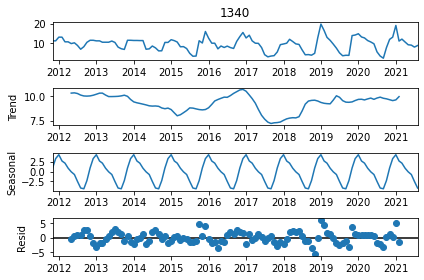

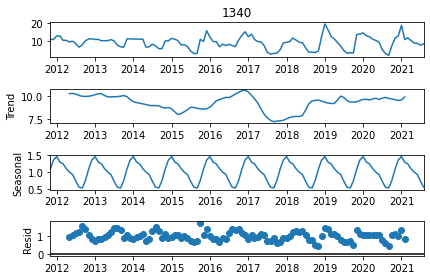

In [32]:
result_add = seasonal_decompose(df['1340'], model='additive', period=12)
result_add.plot();

result_mul = seasonal_decompose(df['1340'], model = 'multiplicative', period = 12)
result_mul.plot();

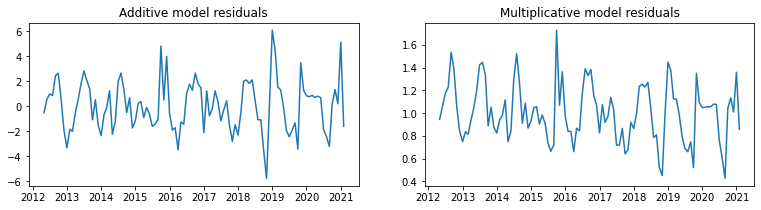

In [33]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,3))
ax1.plot(result_add.resid); ax1.set_title("Additive model residuals")
ax2.plot(result_mul.resid); ax2.set_title("Multiplicative model residuals");

In [34]:
# ADF Test p-values
print('additive resid: ', adfuller(result_add.resid.dropna())[1])
print('multipl resid:  ', adfuller(result_mul.resid.dropna())[1])

additive resid:  5.596863112264111e-10
multipl resid:   1.2044456816273453e-05


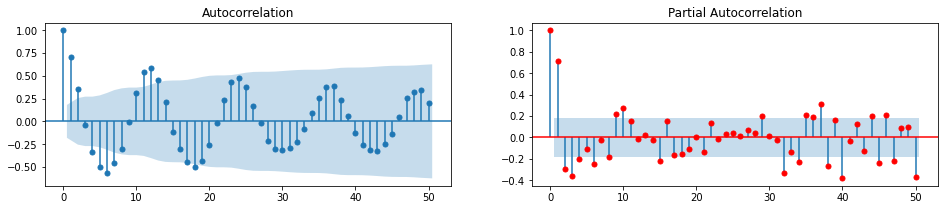

In [35]:
# ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(df['1340'], lags=50, ax=axes[0]);
plot_pacf(df['1340'], lags=50, ax=axes[1], color='r');

In [36]:
def differentials(df):
    zero_diff = df['1340']
    first_order_diff = df['1340'].diff(1)
    second_order_diff = df['1340'].diff(1).diff(1)
    return zero_diff, first_order_diff, second_order_diff
    
def plot_differentials(df):
    
    diffs = differentials(df)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
    ax1.plot(diffs[0]); ax1.set_title('Original Series')
    ax2.plot(diffs[1]); ax2.set_title('1st Order Differencing')
    ax3.plot(diffs[2]); ax3.set_title('2nd Order Differencing');
    
def deseasonalized(df):
    df['deseasonalized'] = df['1340'].values - result_add.seasonal
    df['linearized'] = df['1340'].values - result_add.trend
    return df['deseasonalized'], df['linearized']

def plot_deseasonalized(df):
    deseason = deseasonalized(df)
    plt.figure(figsize=(15,4));
    plt.subplot(1,2,1); plt.plot(deseason[0]);
    plt.title('Deseasonalized', fontsize=16);
    plt.subplot(1,2,2); plt.plot(deseason[1])
    plt.title('Deseasonalized and Linearized', fontsize=16);

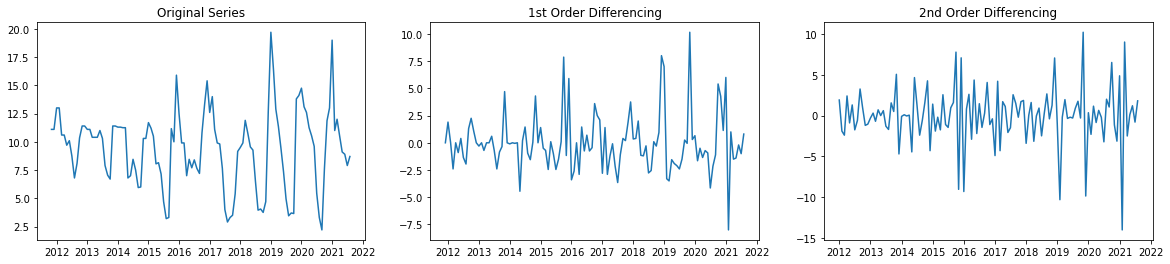

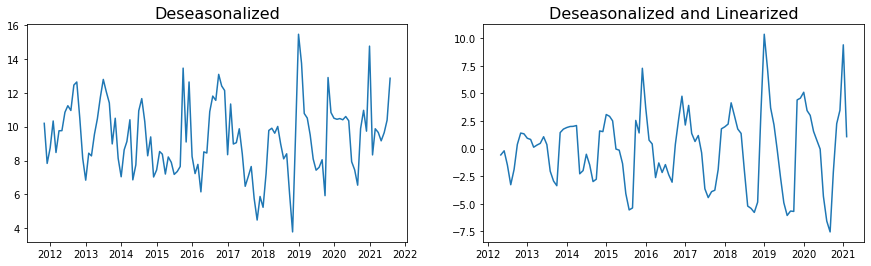

In [26]:
plot_differentials(df)
plot_deseasonalized(df)

In [37]:
p = 4 # déduit de PACF
q = 3 # déduit de ACF
d = 1 # une dérivation

In [38]:
print('p-value zero-diff:   ', adfuller(differentials(df)[0])[1])
print('p-value first-diff:  ', adfuller(differentials(df)[1].dropna())[1])
print('p-value second-diff: ', adfuller(differentials(df)[2].dropna())[1])

p-value zero-diff:    0.053384573143266105
p-value first-diff:   3.3441082795501283e-13
p-value second-diff:  2.0755452094205056e-14


In [40]:
df

,1340,deseasonalized,linearized
date,,,
2011-11-01,11.1,10.193718,NaN
2011-12-01,11.1,7.831681,NaN
2012-01-01,13.0,8.744412,NaN
2012-02-01,13.0,10.332607,NaN
2012-03-01,10.6,8.474439,NaN
...,...,...,...
2021-04-01,10.5,9.654387,NaN
2021-05-01,9.1,9.162205,NaN
2021-06-01,8.9,9.644181,NaN


In [42]:
deseasonalized(df)[0]

date
2011-11-01    10.193718
2011-12-01     7.831681
2012-01-01     8.744412
2012-02-01    10.332607
2012-03-01     8.474439
                ...    
2021-04-01     9.654387
2021-05-01     9.162205
2021-06-01     9.644181
2021-07-01    10.382607
2021-08-01    12.851125
Freq: MS, Name: deseasonalized, Length: 118, dtype: float64

In [43]:
des_df = deseasonalized(df)[0]

In [44]:
des_df.shape

(118,)

In [49]:
# We keep the last 12 months for test
train = deseasonalized(df)[0][:106]
test = deseasonalized(df)[0][106:]

## ARIMA model

In [52]:
arima = ARIMA(train, order=(1,0,0)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98136D+00    |proj g|=  2.08669D-03

At iterate    5    f=  1.98131D+00    |proj g|=  2.22045D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      9      1     0     0   0.000D+00   1.981D+00
  F =   1.9813082952200551     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [51]:
smodel = pm.auto_arima(des_df,
                       start_p=1, max_p=4,
                       start_q=1, max_q=3,
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=507.361, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=870.066, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=513.820, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=746.764, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=674.458, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=508.515, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=510.360, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=483.633, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=490.770, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=481.666, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=515.654, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=483.615, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=485.378, Time

In [53]:
arima_prod = ARIMA(train, order=(1,1,0)).fit()
arima_prod.summary()
forecast_ap, std_err_arima_ap, confidence_int_arima_ap = arima_prod.forecast(len(test), alpha=0.05)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08793D+00    |proj g|=  5.66716D-03

At iterate    5    f=  2.08788D+00    |proj g|=  4.44089D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   4.441D-08   2.088D+00
  F =   2.0878849861367121     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


<AxesSubplot:title={'center':'Density'}, ylabel='Density'>

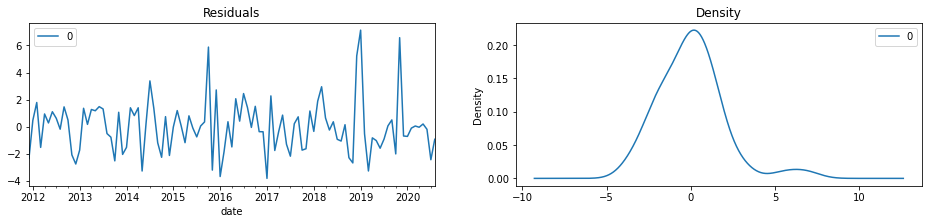

In [54]:
residuals = pd.DataFrame(arima_prod.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])

In [ ]:
forecast_recons = forecast_ap + result_add.seasonal[106:]
train_recons = train + result_add.seasonal[:106]
test_recons = np.exp(test)*result_mul.seasonal[106:]
lower_recons = np.exp(confidence_int_arima_2)[:,0]*result_add.seasonal[106:]
upper_recons = np.exp(confidence_int_arima_2)[:,1]*result_add.seasonal[106:]

# plt 
plot_forecast(forecast_recons, train_recons, test_recons, lower_recons.values, upper_recons.values)